# Linear Spectral Unmixing with Least Squares

### Problem Statement

In the case of spectral data, for a given pixel we suppose to have a set of intensity measurements at different wavelengths, e.g., $I = [I(\lambda_1),I(\lambda_2),\dots,I(\lambda_n)]$, with $n=32$ for instance. For each one of these spectral bands $\lambda_i$, with $i=1,\dots,n$, and for each fluorophore $f$, with $f=1,\dots,m$, we assume to know the reference spectra $R_f=[R_f(\lambda_1), R_f(\lambda_2), \dots, R_f(\lambda_n)]$. Therefore, $I $ is a column vector of size $n$ and $R_f$ are columns of a matrix $\mathbf{R}$ of size $m\times n$. In this context, we define the concentration of the different fluorophores in the sample as a row vector $C = [C_1, C_2, \dots, C_m]$ of size $m$. Therefore, the problem of linear unmixing reads as follows: <br><br>

\begin{equation}
I = C\mathbf{R}
\end{equation}

or, by specifying the vectors and matrix:

\begin{align}
    \begin{bmatrix}
        I(\lambda_1) \\
        I(\lambda_2) \\
        \vdots \\
        I(\lambda_n)
    \end{bmatrix}
        = 
    \begin{bmatrix}
        C_{1} & C_{2} & \dots & C_{m}
    \end{bmatrix}
    \begin{bmatrix}
        R_{1}(\lambda_1) & R_{1}(\lambda_2) & \dots & R_{1}(\lambda_n) \\
        R_{2}(\lambda_1) & R_{2}(\lambda_2) & \dots & R_{2}(\lambda_n) \\
        \vdots & \vdots & \ddots & \vdots \\
        R_{m}(\lambda_1) & R_{m}(\lambda_2) & \dots & R_{m}(\lambda_n) \\
    \end{bmatrix}
\end{align}

### Least Square Estimation

Least Squares is a method that allows to solve the system. It works as follows:

**Goal:** to compute $C$ such that it minimizes the objective $J(C)=||I - C\mathbf{R}||^2$.

**How:** by setting the derivative of $J(C)$ w.r.t. $C$ to $0$. Namely:
\begin{align}
\frac{\partial{J(C)}}{\partial{C}}=-2(I-C\mathbf{R})\mathbf{R}^T=0 \Longrightarrow C\mathbf{R}\mathbf{R}^T=I\mathbf{R}^T \Longrightarrow C=I\mathbf{R}^T(\mathbf{R}\mathbf{R}^T)^{-1} 
\end{align}

**NOTES**

- Notice that in the context of a spectral image we need to repeat this procedure for every pixel.
- $I(\lambda_i)$'s are the intensity values for a given pixel in the mixed image at wavelength $\lambda_i$.
- $R_f(\lambda_i)$'s are the intensity values in the reference spectrum of fluorophore $f$ at wavelength $\lambda_i$.
- For the moment we work with MIP and not with the whole 3D volumes. 

#### 1. Data Preparation

Load mixed image & metadata:

In [3]:
import os
import json
import tifffile as tiff

DATA_DIR = '/Volumes/jug/federico/microsim/sim_spectral_data/240703'

mixed_opt_img = tiff.imread(os.path.join(DATA_DIR, "mips/optical_mixed_mip.tif"))

with open(os.path.join(DATA_DIR, "sim_coords.json"), "r") as f:
    coords_metadata = json.load(f)

Get reference spectra from `FPBase` using `microsim` API:

In [4]:
from microsim.schema.sample import Fluorophore

fp1 = Fluorophore.from_fpbase(name="mTurquoise")
fp2 = Fluorophore.from_fpbase(name="EYFP")
fp3 = Fluorophore.from_fpbase(name="mScarlet")

In [10]:
import xarray as xr

fp1_em = xr.DataArray(fp1.emission_spectrum.intensity, coords=[fp1.emission_spectrum.wavelength.magnitude], dims=["w"])
fp2_em = xr.DataArray(fp2.emission_spectrum.intensity, coords=[fp2.emission_spectrum.wavelength.magnitude], dims=["w"])
fp3_em = xr.DataArray(fp3.emission_spectrum.intensity, coords=[fp3.emission_spectrum.wavelength.magnitude], dims=["w"])

In [16]:
# Bin the emission spectra to the same wavelength range as the data
em_bins = coords_metadata["w_bins"]
sbins = sorted(set([bins[0] for bins in em_bins] + [em_bins[-1][1]]))

fp1_em_binned = fp1_em.groupby_bins(fp1_em["w"], sbins).sum()
fp2_em_binned = fp2_em.groupby_bins(fp2_em["w"], sbins).sum()
fp3_em_binned = fp3_em.groupby_bins(fp3_em["w"], sbins).sum()

In [18]:
# Replace nan values with 0
fp1_em_binned = fp1_em_binned.fillna(0)
fp2_em_binned = fp2_em_binned.fillna(0)
fp3_em_binned = fp3_em_binned.fillna(0)

**OBSERVATION**
The mixed image is a 16bit image (range: 0-6.5e4), whereas the intensity of fluorophores emission spectra ranges in 0-1 before the binning.

Intuitively, intensity ranges should be the same. However does this really matter?

In my understanding, the answer is NO. Let's see why:

- Suppose the case of 0-1 range normalization. In that case, normalization is obtained by simply dividing each pixel's intensity by the maximum intensity in the image. In other terms we basically divide by a scalar. Therefore, supposing that we normalize in this way both the mixed image and the reference spectra, the linear system becomes:

\begin{equation}
\frac{1}{k_I}I = \frac{1}{k_R}C\mathbf{R}
\end{equation}

where $k_I$ and $k_R$ are scalar. Therefore the solution of this system is the same up to some multiplicative constants.

Therefore, we can normalize everything in the range 0-1 so that quantities are in the same scale.

In [20]:
mixed_opt_img = mixed_opt_img / mixed_opt_img.max()
fp1_em_binned = fp1_em_binned / fp1_em_binned.max()
fp2_em_binned = fp2_em_binned / fp2_em_binned.max()
fp3_em_binned = fp3_em_binned / fp3_em_binned.max()

Prepare the matrix R of reference fluorophore intensities:

In [27]:
import numpy as np

fp_ref_matrix = np.stack([fp1_em_binned.values, fp2_em_binned.values, fp3_em_binned.values], axis=0)

#### 2. Compute the LS solution

In [30]:
mixed_opt_img.shape

(32, 512, 512)

In [47]:
from scipy.linalg import lstsq

def lstsq_fit(mixed_img, fp_ref_matrix):
    n_bins, n_rows, n_cols = mixed_img.shape
    n_fps = fp_ref_matrix.shape[0]

    fp_conc_img = np.zeros((n_fps, n_rows, n_cols))

    for r in range(n_rows):
        for c in range(n_cols):
            mixed_pixel = mixed_img[1:, r, c]  # exclude first bin
            fp_conc, residuals, rank, sing_vals = lstsq(fp_ref_matrix.T, mixed_pixel)
            fp_conc_img[:, r, c] = fp_conc

    return fp_conc_img

In [48]:
fp_concentration_img = lstsq_fit(mixed_opt_img, fp_ref_matrix)

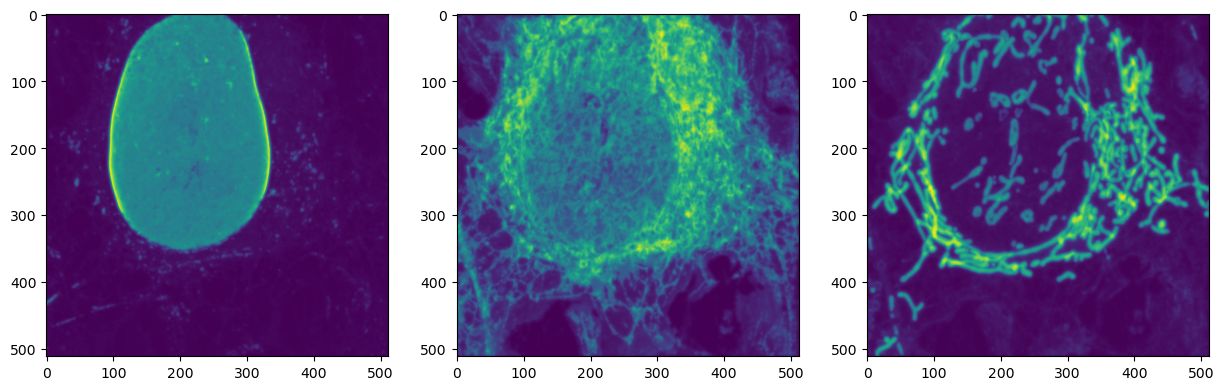

In [57]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(fp_concentration_img[0, :, :])
ax[1].imshow(fp_concentration_img[1, :, :])
ax[2].imshow(fp_concentration_img[2, :, :])